In [3]:
!7za -y x "/content/drive/MyDrive/datascience project/data/image"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/datascience project/data/                                                          1 folder, 8 files, 8113576419 bytes (7738 MiB)
  0%    
Extracting archive: /content/drive/MyDrive/datascience project/data/image/origin.7z.001
--
Path = /content/drive/MyDrive/datascience project/data/image/origin.7z.001
Type = Split
Physical Size = 1048576000
Volumes = 8
Total Physical Size = 8113576419
----
Path = origin.7z
Size = 8113576419
--
Path = origin.7z
Type = 7z
Physical Size = 8113576419
Headers Size = 863607
Method = LZMA:25
Solid = +
Blocks = 2

  0%      0% - origin/afraid_African_214.jpg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

!cp -r ./origin "/content/drive/MyDrive/datascience project/origin.7z*"

In [10]:
label_file_path=r"/content/drive/MyDrive/datascience project/data/label/label.lst"
images_folder_path=r"/content/drive/MyDrive/datascience project/origin.7z*"

In [12]:
import pandas as pd
df_info=pd.read_csv(label_file_path, sep=" ",header=None)
df_info.columns=['image_name','face_id_in_image','face_box_top','face_box_left','face_box_right','face_box_bottom','face_box_cofidence','expression_label']
df_info.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_cofidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


In [13]:
df_info.shape

(91793, 8)

In [14]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df_info['expression_label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['expression_label', 'number']
emotion_counts['expression_label'] = emotion_counts['expression_label'].map(emotion_map)
emotion_counts

,expression_label,number
0,Angry,3671
1,Fear,1088
2,Happy,30537
3,Neutral,34883
4,Sad,10559
5,Digust,3995
6,Surprise,7060


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns



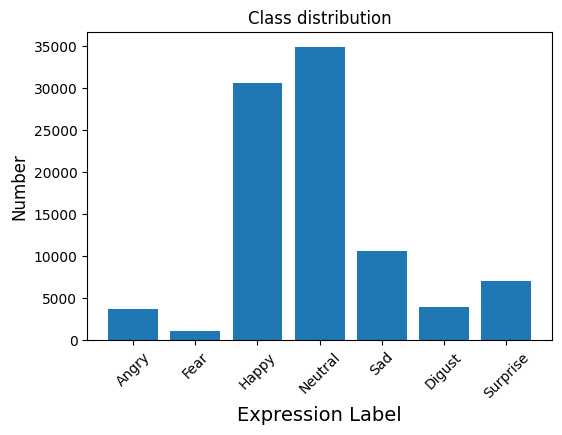

In [16]:
emotion_counts = pd.DataFrame(emotion_counts, columns=["expression_label", "number"])
plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.expression_label, emotion_counts.number)
plt.title('Class distribution')
plt.xlabel('Expression Label', fontsize=14)
plt.ylabel('Number', fontsize=12)
plt.xticks(rotation=45)  # To rotate the x-axis labels for better visibility
plt.show()

In [17]:
df_info.value_counts()

image_name                  face_id_in_image  face_box_top  face_box_left  face_box_right  face_box_bottom  face_box_cofidence  expression_label
awe_teacher_108.jpg         1                 600           1524           1572            648              72.4882             3                   37
astound_expression_400.jpg  3                 288           308            388             368              72.5160             3                   16
awe_student_400.jpg         2                 664           388            436             712              82.8833             6                   13
amazed_chinese_563.jpg      3                 652           1908           1956            700              56.7663             6                   12
                            1                 176           576            624             224              57.5098             6                   12
                                                                                                    

In [18]:
df_sel=df_info[df_info.face_box_cofidence > 80]
#print(df_sel)
len(df_sel)


12127

In [19]:
df_sel.shape

(12127, 8)

In [20]:
df_sel.columns

Index(['image_name', 'face_id_in_image', 'face_box_top', 'face_box_left',
       'face_box_right', 'face_box_bottom', 'face_box_cofidence',
       'expression_label'],
      dtype='object')

In [21]:
df_sel.image_name

3                    angry_actor_13.jpg
4                   angry_actor_132.jpg
5                   angry_actor_137.jpg
9                   angry_actor_150.jpg
12                  angry_actor_161.jpg
                      ...              
91778       surprised_expression_37.jpg
91780      surprised_expression_289.jpg
91787    expressionless_husband_673.jpg
91789      surprised_expression_381.jpg
91790      surprised_expression_395.jpg
Name: image_name, Length: 12127, dtype: object

In [22]:
import cv2
import os
import concurrent.futures

x = []
y = []

def process_image(row):
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    y1 = row["face_box_top"]
    x2 = row["face_box_right"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_folder_path, img_name)

    image = cv2.imread(img_path)

    if image is not None:
        cropped = image[y1:y2, x1:x2]
    else:
        return None, None

    if cropped is not None:
        resized_face = cv2.resize(cropped, (64, 64))
    else:
        return None, None

    return resized_face, label

# Function to process images in parallel
def process_images_in_parallel(dataframe):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_row = {executor.submit(process_image, row): row for i, row in dataframe.sample(12000).iterrows()}

        for future in concurrent.futures.as_completed(future_to_row):
            row = future_to_row[future]
            resized_face, label = future.result()
            if resized_face is not None:
                x.append(resized_face)
                y.append(label)

# Call the function to process images in parallel
process_images_in_parallel(df_sel)


In [25]:
print(x)
print(y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
len(x)

12000

In [27]:
#Data preparation
import numpy as np
X= np.array(x)
y= np.array(y)


In [28]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical



# Step 1: Normalization
X_normalized = X / 255.0

# Step 2: Sampling (optional)
sample_size = 3500
random_indices = np.random.choice(len(X_normalized), size=sample_size )
X_sampled = X_normalized[random_indices]
Y_sampled = y[random_indices]

# Step 3: Encoding (for classification task)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_sampled)

# Step 4: Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_encoded, test_size=0.2, random_state=42)

# Step 5: Load and Fine-tune VGG16 Model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

# Freeze the layers so that they are not updated during training
for layer in vgg16.layers:
    layer.trainable = False

# Add custom layers on top of VGG16 for classification
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=vgg16.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

# Calculate accuracy on test data
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test accuracy: {accuracy:.2f}")


58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
88/88 [==============================] - 21s 40ms/step - loss: 1.3914 - accuracy: 0.4907 - val_loss: 1.2217 - val_accuracy: 0.5529
Epoch 2/10
88/88 [==============================] - 2s 25ms/step - loss: 1.1705 - accuracy: 0.5704 - val_loss: 1.2363 - val_accuracy: 0.5600
Epoch 3/10
88/88 [==============================] - 2s 24ms/step - loss: 1.0468 - accuracy: 0.6275 - val_loss: 1.1414 - val_accuracy: 0.6071
Epoch 4/10
88/88 [==============================] - 2s 24ms/step - loss: 0.9442 - accuracy: 0.6607 - val_loss: 1.1446 - val_accuracy: 0.6057
Epoch 5/10
88/88 [==============================] - 2s 21ms/step - loss: 0.8103 - accuracy: 0.7221 - val_loss: 1.1546 - val_accuracy: 0.6029
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.7149 - accuracy: 0.7525 - val_loss: 1.4043 - val_accuracy: 0.5471
Epoch 7/10
88/88 [==============================] - 2s 22ms/step - loss: 0.6422 - accura

Epoch 1/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2701 - accuracy: 0.9125 - val_loss: 1.5236 - val_accuracy: 0.6157
Epoch 2/10
88/88 [==============================] - 2s 24ms/step - loss: 0.1959 - accuracy: 0.9475 - val_loss: 1.5547 - val_accuracy: 0.6200
Epoch 3/10
88/88 [==============================] - 2s 25ms/step - loss: 0.1892 - accuracy: 0.9414 - val_loss: 1.7305 - val_accuracy: 0.6200
Epoch 4/10
88/88 [==============================] - 2s 23ms/step - loss: 0.1369 - accuracy: 0.9586 - val_loss: 1.8040 - val_accuracy: 0.6429
Epoch 5/10
88/88 [==============================] - 2s 25ms/step - loss: 0.0852 - accuracy: 0.9807 - val_loss: 2.0134 - val_accuracy: 0.6543
Epoch 6/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0610 - accuracy: 0.9875 - val_loss: 1.9448 - val_accuracy: 0.6029
Epoch 7/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0329 - accuracy: 0.9971 - val_loss: 1.9880 - val_accuracy: 0.6457
Epoch 8/10
88

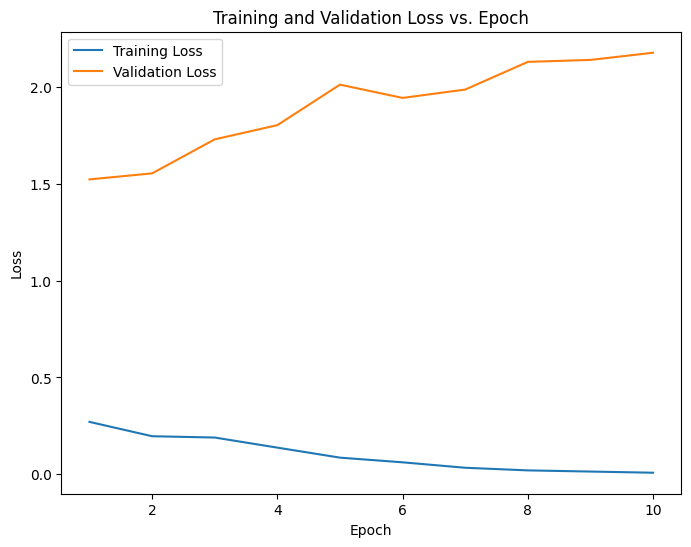

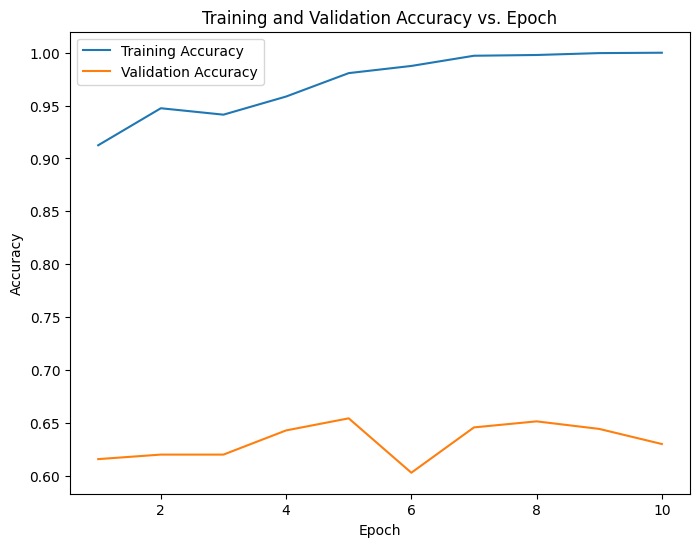

In [29]:
import matplotlib.pyplot as plt

# Train the model and store training history
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

# Get training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the Loss vs. Epoch graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.show()

# Plot the Accuracy vs. Epoch graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()
